<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/kmedoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn-extra &> /dev/null

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import time
from scipy.spatial.distance import cdist
# from sklearn.decomposition import PCA

In [ ]:
seed = 0

In [ ]:
def k_medoids(X, k, max_iter=100, tol=1e-4, metric='euclidean'):
    n = len(X)
    rng = np.random.default_rng(seed)
    medoid_indices = rng.choice(n, k, replace=False)
    medoids = X[medoid_indices]
    prev_medoids = np.zeros_like(medoids)
    labels = np.zeros(n, dtype=int)

    for _ in range(max_iter):
        # Assign each point to the nearest medoid
        distances = cdist(X, medoids, metric)
        labels = np.argmin(distances, axis=1)

        # Swap step: Try replacing medoids with non-medoids and check cost
        for i, medoid in enumerate(medoids):
            cluster_points = X[labels == i]
            best_medoid = medoid
            best_cost = np.sum(cdist(cluster_points, [medoid], metric))

            for point in cluster_points:
                cost = np.sum(cdist(cluster_points, [point], metric))
                if cost < best_cost:
                    best_medoid = point
                    best_cost = cost

            medoids[i] = best_medoid

        # Convergence check
        if np.allclose(prev_medoids, medoids, atol=tol):
            break
        prev_medoids = medoids.copy()

    return labels, medoids

In [ ]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()
k_iris = 3

print("Iris Dataset\n")

start_time = time.time()
labels_base_iris, centroids_base_iris = k_medoids(X_iris, k_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_iris, labels_base_iris)}")

start_time = time.time()
kmedoids_iris = KMedoids(n_clusters=k_iris, random_state=seed).fit(X_iris)
labels_sklearn_iris = kmedoids_iris.labels_
centroids_sklearn_iris = kmedoids_iris.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_iris, labels_sklearn_iris)}")

Iris Dataset

Execution time (base): 0.013979911804199219 seconds
DBI score (base): 0.662322864989869

Execution time (sklearn): 0.005272388458251953 seconds
DBI score (sklearn): 0.6690341629005112


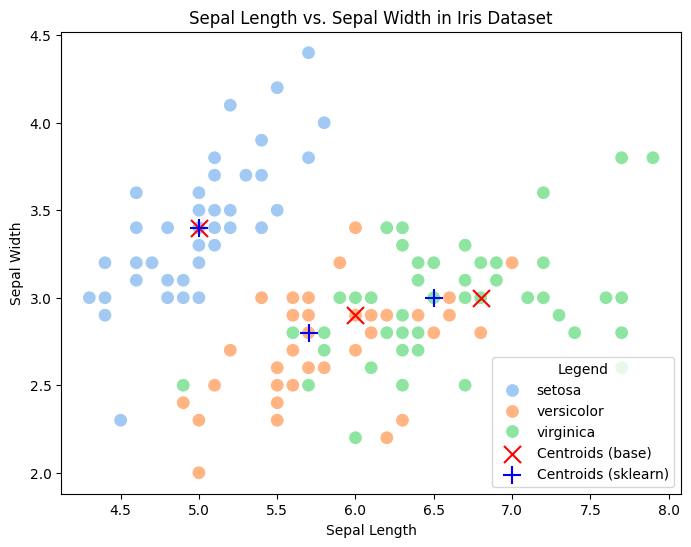

In [ ]:
# centroids_base_iris = scaler_iris.inverse_transform(centroids_base_iris)
# centroids_sklearn_iris = scaler_iris.inverse_transform(centroids_sklearn_iris)

slength_idx = list(iris_filtered.columns).index("sepal_length")
swidth_idx = list(iris_filtered.columns).index("sepal_width")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="pastel", s=100)
plt.scatter(centroids_base_iris[:, slength_idx], centroids_base_iris[:, swidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_iris[:, slength_idx], centroids_sklearn_iris[:, swidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
plt.legend(title="Legend")
plt.show()

In [ ]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

X_ai = ai_filtered.to_numpy()
k_ai = 3

print("AI Global Index")

start_time = time.time()
labels_base_ai, centroids_base_ai = k_medoids(X_ai, k_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_ai, labels_base_ai)}")

start_time = time.time()
k_medoids_ai = KMedoids(n_clusters=k_ai, random_state=seed).fit(X_ai)
labels_sklearn_ai = k_medoids_ai.labels_
centroids_sklearn_ai = k_medoids_ai.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_ai, labels_sklearn_ai)}")

AI Global Index
Execution time (base): 0.011687755584716797 seconds
DBI score (base): 1.3040437893814811

Execution time (sklearn): 0.0030629634857177734 seconds
DBI score (sklearn): 1.8891196054100152


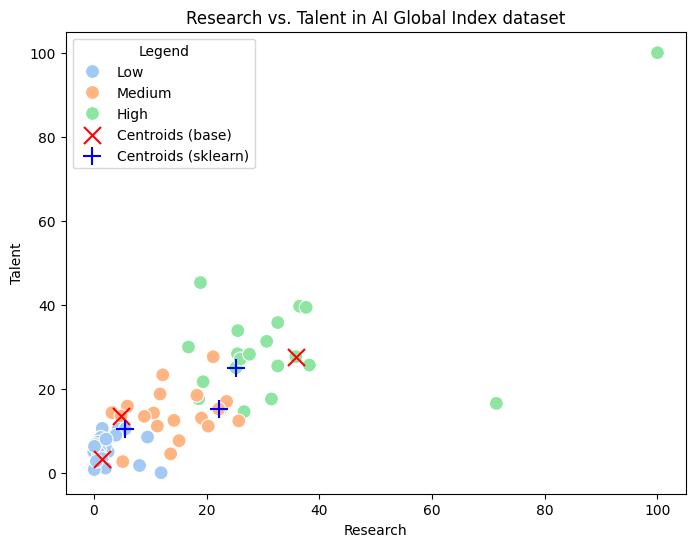

In [ ]:
# centroids_base_ai = scaler_ai.inverse_transform(centroids_base_ai)
# centroids_sklearn_ai = scaler_ai.inverse_transform(centroids_sklearn_ai)

research_idx = list(ai_filtered.columns).index("Research")
talent_idx = list(ai_filtered.columns).index("Talent")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Research")
plt.ylabel("Talent")
plt.title("Research vs. Talent in AI Global Index dataset")
plt.legend(title="Legend")
plt.show()

In [ ]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode", "felt"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_medoids(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_earth, labels_base_earth)}")

start_time = time.time()
kmedoids_earth = KMedoids(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmedoids_earth.labels_
centroids_sklearn_earth = kmedoids_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
Execution time (base): 0.3063395023345947 seconds
DBI score (base): 0.8667280458131195

Execution time (sklearn): 0.1938183307647705 seconds
DBI score (sklearn): 0.7333271529472086


/usr/local/lib/python3.11/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


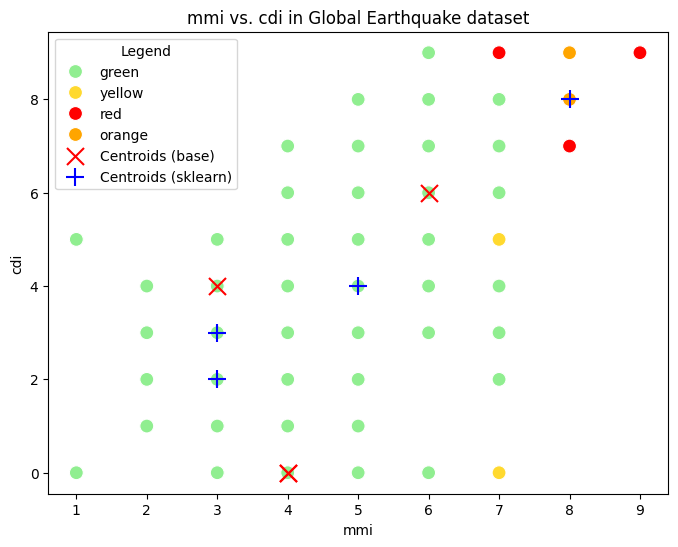

In [ ]:
cdi_idx = list(earthquakes_filtered.columns).index("cdi")
mmi_idx = list(earthquakes_filtered.columns).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("cdi")
plt.title("mmi vs. cdi in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [ ]:
earthquakes.describe()

,magnitude,cdi,mmi,sig,rms,depth
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000
mean,4.856675,2.925242,4.320141,432.698329,0.585974,41.287300
std,1.047840,2.562707,1.453949,256.177844,0.308556,87.866489
min,3.000000,0.000000,1.000000,138.000000,0.000000,-0.250000
25%,3.800000,0.000000,4.000000,234.000000,0.300000,7.550000
50%,5.300000,3.000000,4.000000,449.000000,0.630000,10.000000
75%,5.600000,5.000000,5.000000,518.000000,0.780000,34.723000
max,7.600000,9.000000,9.000000,2419.000000,2.520000,639.503000
